In [16]:
import cv2
import matplotlib.pyplot as plt
from fonctions_image import *

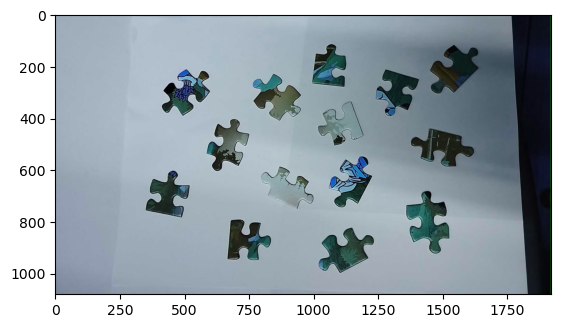

In [17]:
puzzle = cv2.imread('../nos_puzzles/yakari.jpg')
image_test = cv2.imread("../frame.jpg")

plt.imshow(image_test)

Found 14 valid pieces
Piece areas: [16801, 21143, 22401, 18138, 21982, 18195, 21568, 19616, 21445, 19224, 20502, 24514, 19820, 23175]

Piece 0:
Position: (971, 92)
Size: (185, 217)
Area: 16801

Piece 1:
Position: (1428, 97)
Size: (232, 237)
Area: 21143

Piece 2:
Position: (388, 188)
Size: (240, 233)
Area: 22401

Piece 3:
Position: (1220, 189)
Size: (218, 232)
Area: 18138

Piece 4:
Position: (740, 207)
Size: (241, 231)
Area: 21982

Piece 5:
Position: (995, 310)
Size: (225, 225)
Area: 18195

Piece 6:
Position: (562, 381)
Size: (219, 252)
Area: 21568

Piece 7:
Position: (1351, 418)
Size: (292, 197)
Area: 19616

Piece 8:
Position: (1036, 525)
Size: (218, 252)
Area: 21445

Piece 9:
Position: (773, 564)
Size: (256, 217)
Area: 19224

Piece 10:
Position: (325, 582)
Size: (224, 230)
Area: 20502

Piece 11:
Position: (1332, 664)
Size: (221, 286)
Area: 24514

Piece 12:
Position: (643, 767)
Size: (220, 208)
Area: 19820

Piece 13:
Position: (996, 794)
Size: (266, 231)
Area: 23175


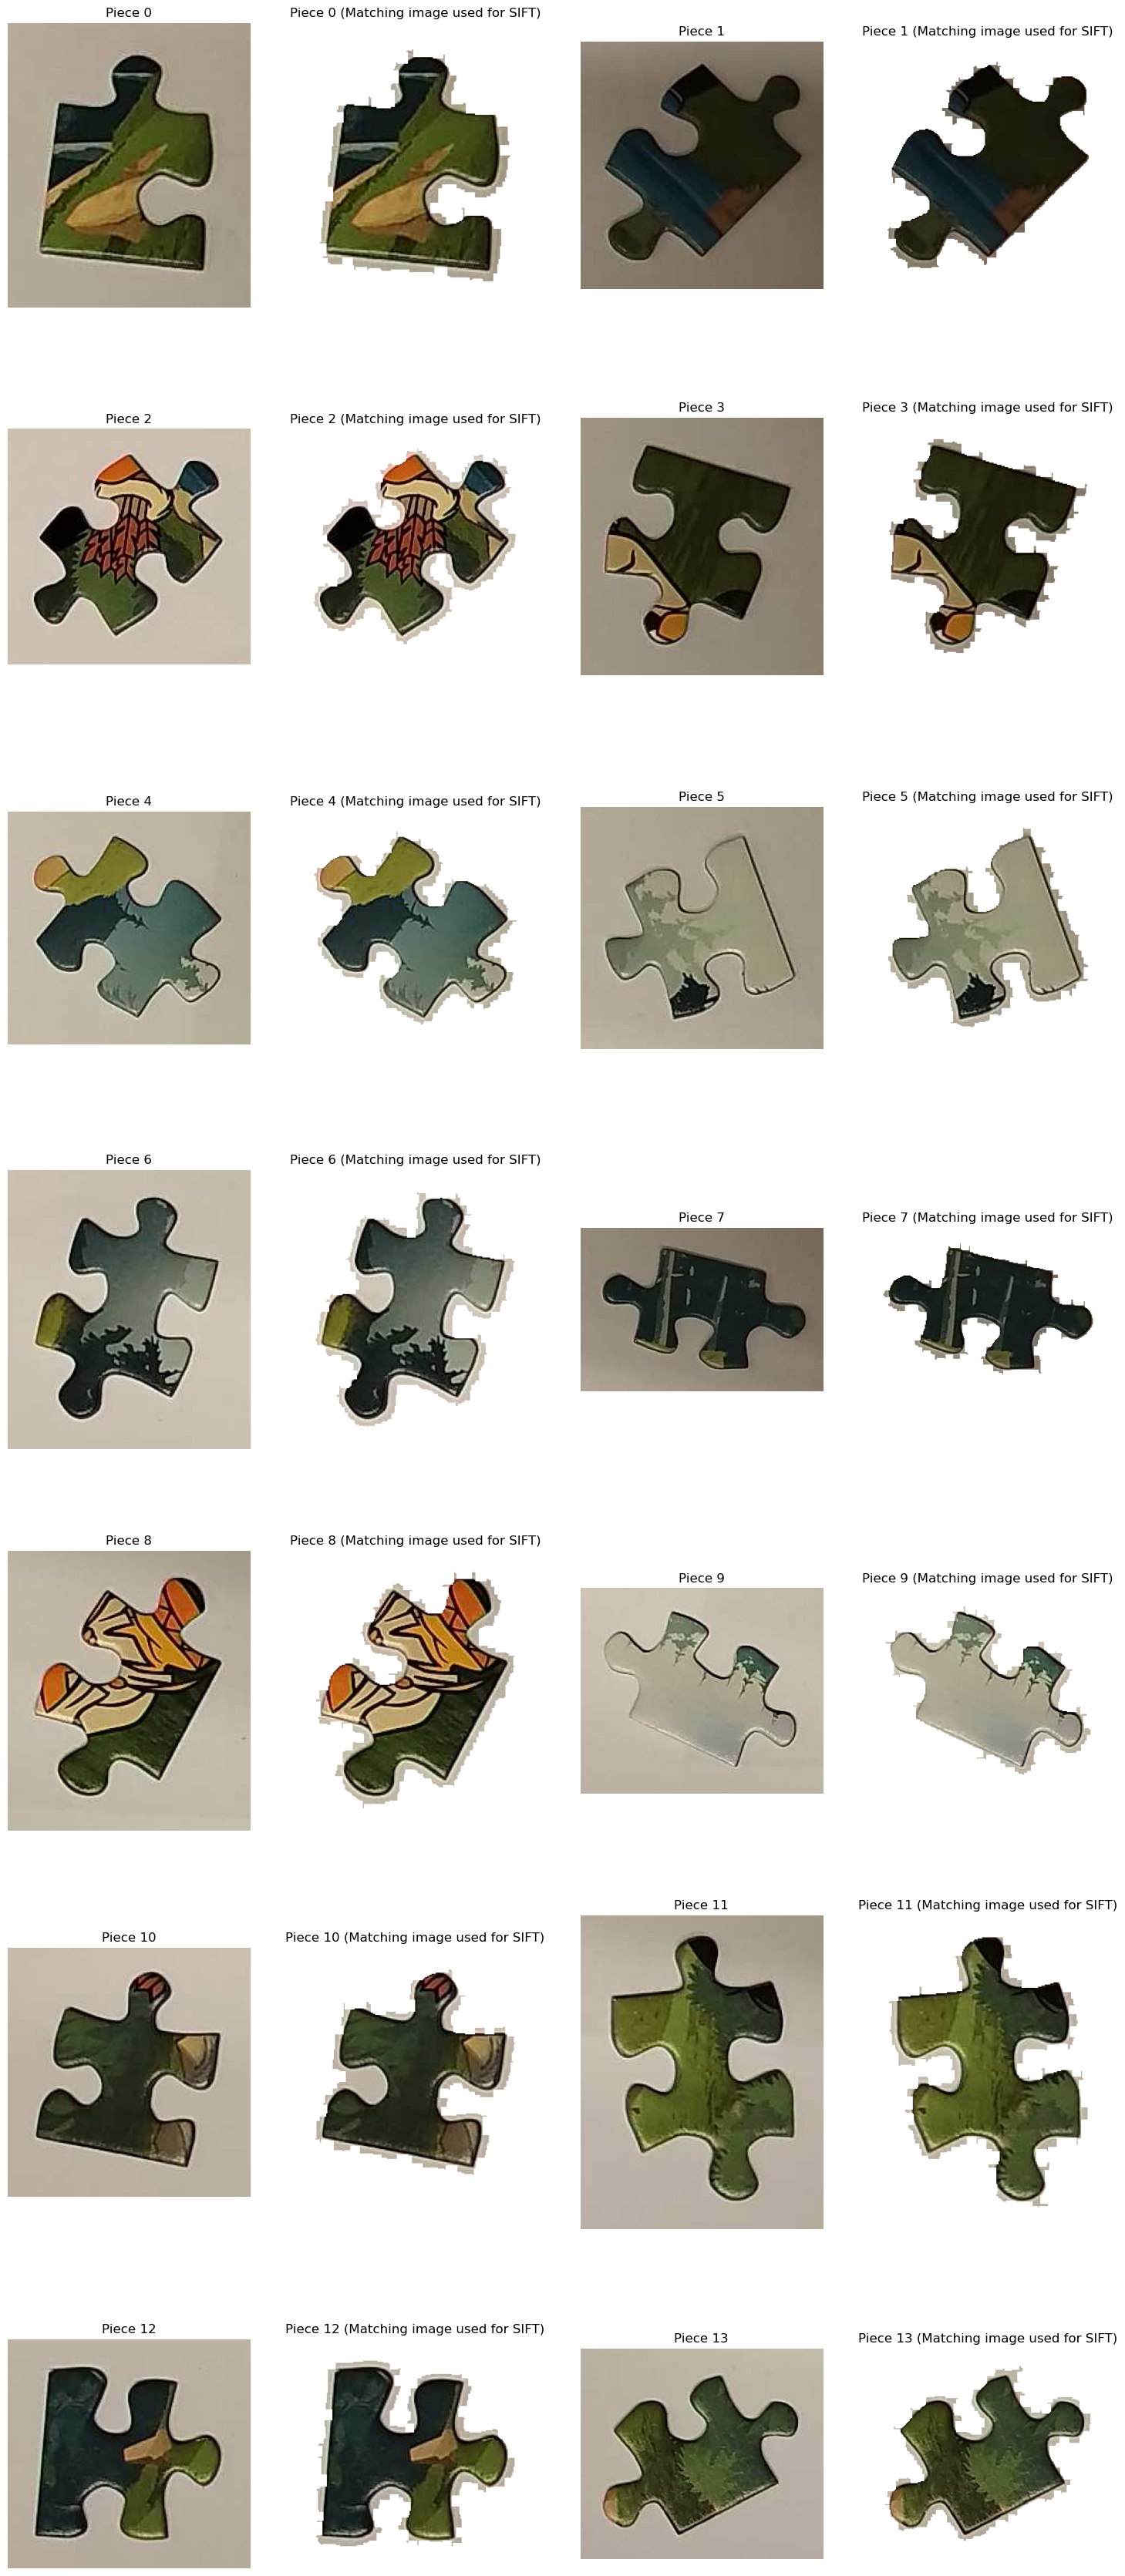

In [18]:
pieces = extract_pieces(image_test)
show_found_pieces(pieces)


### Idée : on réduit le masque pour enlever toutes les features au bord

In [19]:
def filter_keypoints_by_mask(keypoints, descriptors, mask, margin=10):
    height, width = mask.shape
    kernel = np.ones((margin*2+1, margin*2+1), np.uint8)
    eroded_mask = cv2.erode(mask.astype(np.uint8), kernel)
    
    filtered_keypoints = []
    filtered_descriptors = []
    
    for i, kp in enumerate(keypoints):
        x, y = map(int, kp.pt)
        if 0 <= y < height and 0 <= x < width and eroded_mask[y, x] > 0:
            filtered_keypoints.append(kp)
            filtered_descriptors.append(descriptors[i])
    
    return filtered_keypoints, np.array(filtered_descriptors)

### Sift

In [20]:
sift = cv2.SIFT_create()
bf = cv2.BFMatcher()

keypoints_full, descriptors_full = sift.detectAndCompute(puzzle, None)

In [21]:
def calculate_keypoints(piece) :
    keypoints_piece, descriptors_piece = sift.detectAndCompute(piece["matching_image"], None)
    
    keypoints_piece, descriptors_piece = filter_keypoints_by_mask(
    keypoints_piece,
    descriptors_piece,
    piece["binary_mask"]
    )
    drawn_keypoints = cv2.drawKeypoints(piece["matching_image"], keypoints_piece, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(drawn_keypoints)
    
    return keypoints_piece, descriptors_piece

In [22]:
def calculate_matches(piece, puzzle, keypoints_piece, descriptors_piece) :
    
    matches = bf.knnMatch(descriptors_piece, descriptors_full, k=2)
    good_matches = []
    for m, n in matches:
        if m.distance < 0.8 * n.distance:  # Lowe's ratio test
            good_matches.append(m)
            
    print(f'Found {len(good_matches)} matches') 
    good_matches = sorted(good_matches, key=lambda x: x.distance)[:20]
    good_matches = get_spatially_consistent_matches(good_matches, keypoints_full, piece['size'])
            
    matched_img = cv2.drawMatches(piece['image'], keypoints_piece,
                               puzzle, keypoints_full,
                                good_matches, None,
                                matchColor=(0, 255, 0),
                                matchesThickness=3)
    
    matched_img = cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB)
    plt.imshow(matched_img)

    return good_matches

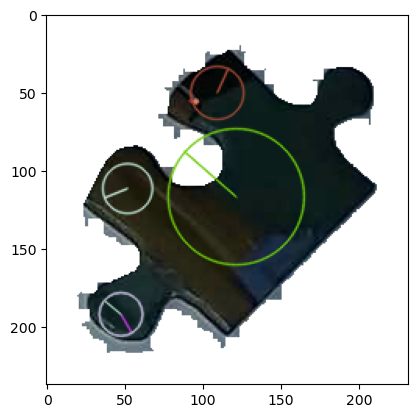

In [23]:
piece = pieces[1]
keypoints_piece, descriptors_piece = calculate_keypoints(piece)

Found 0 matches


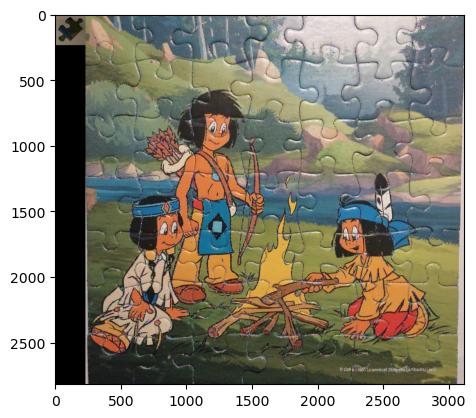

In [24]:
matches = calculate_matches(piece, puzzle, keypoints_piece, descriptors_piece)

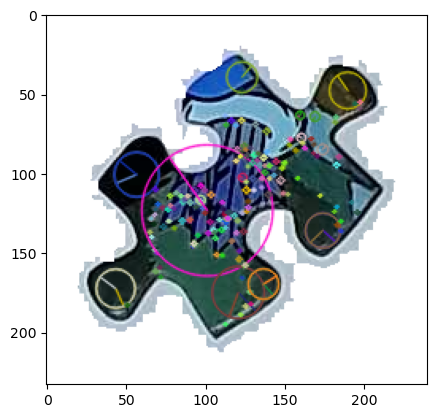

In [25]:
piece = pieces[2]
keypoints_piece, descriptors_piece = calculate_keypoints(piece)

Found 52 matches


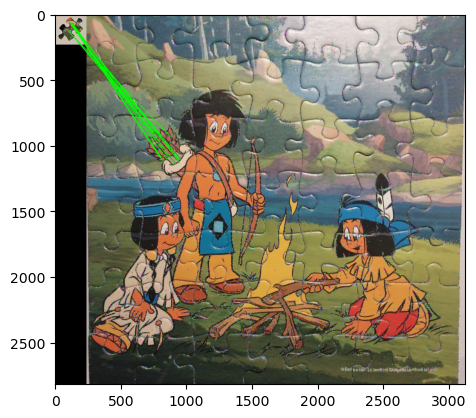

In [26]:
matches = calculate_matches(piece, puzzle, keypoints_piece, descriptors_piece)

### Akaze

In [27]:
akaze = cv2.AKAZE_create()
bf = cv2.BFMatcher(cv2.NORM_HAMMING)

keypoints_full, descriptors_full = akaze.detectAndCompute(puzzle, None)


In [28]:
def calculate_keypoints_akaze(piece) :
    keypoints_piece, descriptors_piece = akaze.detectAndCompute(piece["matching_image"], None)
    
    keypoints_piece, descriptors_piece = filter_keypoints_by_mask(
    keypoints_piece,
    descriptors_piece,
    piece["binary_mask"]
)
    
    drawn_keypoints = cv2.drawKeypoints(piece["matching_image"], keypoints_piece, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(drawn_keypoints)
    
    return keypoints_piece, descriptors_piece

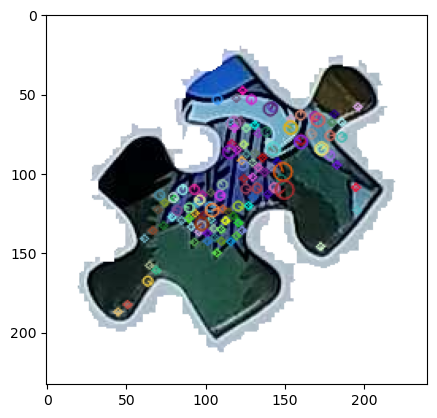

In [29]:
piece = pieces[2]
keypoints_piece, descriptors_piece = calculate_keypoints_akaze(piece)

Found 7 matches


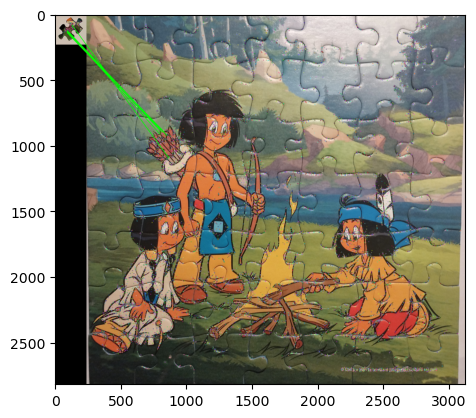

In [30]:
matches = calculate_matches(piece, puzzle, keypoints_piece, descriptors_piece)